In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/laszlofreund/miniconda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/laszlofreund/miniconda/lib/python3.10/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
class Classifier(nn.Module):
    def __init__(self, KERNEL_SIZE=(3, 3), INPUT_SHAPE=(3, 32, 32)):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, KERNEL_SIZE, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, KERNEL_SIZE, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(32, 64, KERNEL_SIZE, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, KERNEL_SIZE, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv5 = nn.Conv2d(64, 128, KERNEL_SIZE, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, KERNEL_SIZE, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)

        self.groupnorm = nn.GroupNorm(32, 128)
        self.activation = nn.SiLU()
        self.zeropad1 = nn.ZeroPad2d((1, 1, 1, 1))
        self.conv7 = nn.Conv2d(128, 16, 3, stride=1)
        self.zeropad2 = nn.ZeroPad2d((1, 1, 1, 1))
        self.conv8 = nn.Conv2d(16, 8, 1, stride=1)

        self.flatten = nn.Flatten()
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(8 * 6 * 6, 128)
        self.dropout4 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.groupnorm(x)
        x = self.activation(x)
        x = self.zeropad1(x)
        x = self.conv7(x)
        x = self.zeropad2(x)
        x = self.conv8(x)

        x = self.flatten(x)
        x = self.dropout3(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

In [4]:
# Load CIFAR-10 trainset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Load CIFAR-10 testset
testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Set batch size
batch_size = 128

# Create train and test dataloaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = Classifier().to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0

Epoch [1/10], Step [100/391], Loss: 2.1862
Epoch [1/10], Step [200/391], Loss: 2.1168
Epoch [1/10], Step [300/391], Loss: 2.0779
Epoch [2/10], Step [100/391], Loss: 2.0483
Epoch [2/10], Step [200/391], Loss: 2.0378
Epoch [2/10], Step [300/391], Loss: 2.0434
Epoch [3/10], Step [100/391], Loss: 2.0073
Epoch [3/10], Step [200/391], Loss: 1.9969
Epoch [3/10], Step [300/391], Loss: 1.9925
Epoch [4/10], Step [100/391], Loss: 1.9665
Epoch [4/10], Step [200/391], Loss: 1.9644
Epoch [4/10], Step [300/391], Loss: 1.9552
Epoch [5/10], Step [100/391], Loss: 1.9320
Epoch [5/10], Step [200/391], Loss: 1.9301
Epoch [5/10], Step [300/391], Loss: 1.9188
Epoch [6/10], Step [100/391], Loss: 1.9048
Epoch [6/10], Step [200/391], Loss: 1.8938
Epoch [6/10], Step [300/391], Loss: 1.8940
Epoch [7/10], Step [100/391], Loss: 1.8777
Epoch [7/10], Step [200/391], Loss: 1.8759
Epoch [7/10], Step [300/391], Loss: 1.8774
Epoch [8/10], Step [100/391], Loss: 1.8638
Epoch [8/10], Step [200/391], Loss: 1.8665
Epoch [8/10

In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 65.10%


In [30]:
import mei
Mei = mei.MEI(model, trainloader)

[32, 32, 3]
Working with images with mu=0.0037017855793237686, sigma=0.02222735621035099


In [31]:
Mei.propogate(0)

Working on neuron_id=0


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 32, 3, 3] to have 3 channels, but got 32 channels instead

In [29]:
Mei.mei

array([[126.00769432, 124.7988393 , 143.78924915, 133.31139338,
        138.24349794, 132.83791464, 124.93505899, 123.31955223,
        124.48463138, 127.42210854, 120.67224813, 126.54970166,
        124.46318877, 116.41260116, 119.93190004, 123.38086239,
        109.9761843 , 120.20195986, 112.08558214, 135.13259226,
        117.70169645, 125.77201179, 130.51974719, 125.86058716,
        140.39927057, 130.65940993, 121.52494058, 116.35437512],
       [125.7109808 , 142.61349523, 134.00185053, 134.17421556,
        134.70334138, 132.59763252, 124.07864433, 115.53721651,
        128.02663575, 131.255283  , 121.34636743, 139.73913616,
        119.23920956, 123.46389432, 117.27990329, 121.94815616,
        116.35127771, 135.34453239, 128.87769308, 106.93276366,
        123.64350437, 124.3767005 , 132.24879472, 128.97508212,
        137.42070284, 123.52499178, 137.63663105, 138.9860129 ],
       [136.93886241, 129.50396865, 137.38119421, 131.23038405,
        126.38438224, 119.67317967, 11

TypeError: Image data of dtype object cannot be converted to float

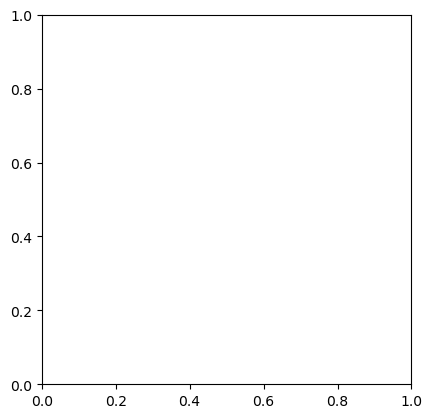

In [63]:
import matplotlib.pyplot as plt

plt.imshow(Mei.mei, cmap='gray')
plt.axis('off')
plt.show()

In [29]:
import importlib
importlib.reload(mei)

<module 'mei' from '/Users/laszlofreund/code/ai/mei/torch/mei/mei.py'>